Using device: cuda
Downloaded 8760 candles...
Downloaded 8760 candles
Data shape: (8760, 7)
Data with features: (8711, 36)
Observation shape: (36,)
Features: market(19) + position(7) + risk(7) + regime(3) = 36
Train data: 6968 samples
Test data: 1743 samples
Training Advanced DQN Agent...
Episode 0: Profit: -0.53%, Trades: 50, Sharpe: 0.00, Avg Trades: 50.0, Steps: 6967
Episode 10: Profit: -0.56%, Trades: 50, Sharpe: 0.00, Avg Trades: 46.6, Steps: 6967
Episode 20: Profit: -0.20%, Trades: 50, Sharpe: 0.00, Avg Trades: 50.0, Steps: 6967
Episode 30: Profit: -0.47%, Trades: 50, Sharpe: 0.00, Avg Trades: 47.6, Steps: 6967
Episode 40: Profit: -0.57%, Trades: 50, Sharpe: 0.00, Avg Trades: 48.4, Steps: 6967
Episode 50: Profit: -100.00%, Trades: 28, Sharpe: -3.74, Avg Trades: 45.6, Steps: 781
Episode 60: Profit: -0.47%, Trades: 50, Sharpe: 0.00, Avg Trades: 42.4, Steps: 6967
Episode 70: Profit: -0.50%, Trades: 50, Sharpe: 0.00, Avg Trades: 50.0, Steps: 6967
Episode 80: Profit: -0.47%, Trades: 5

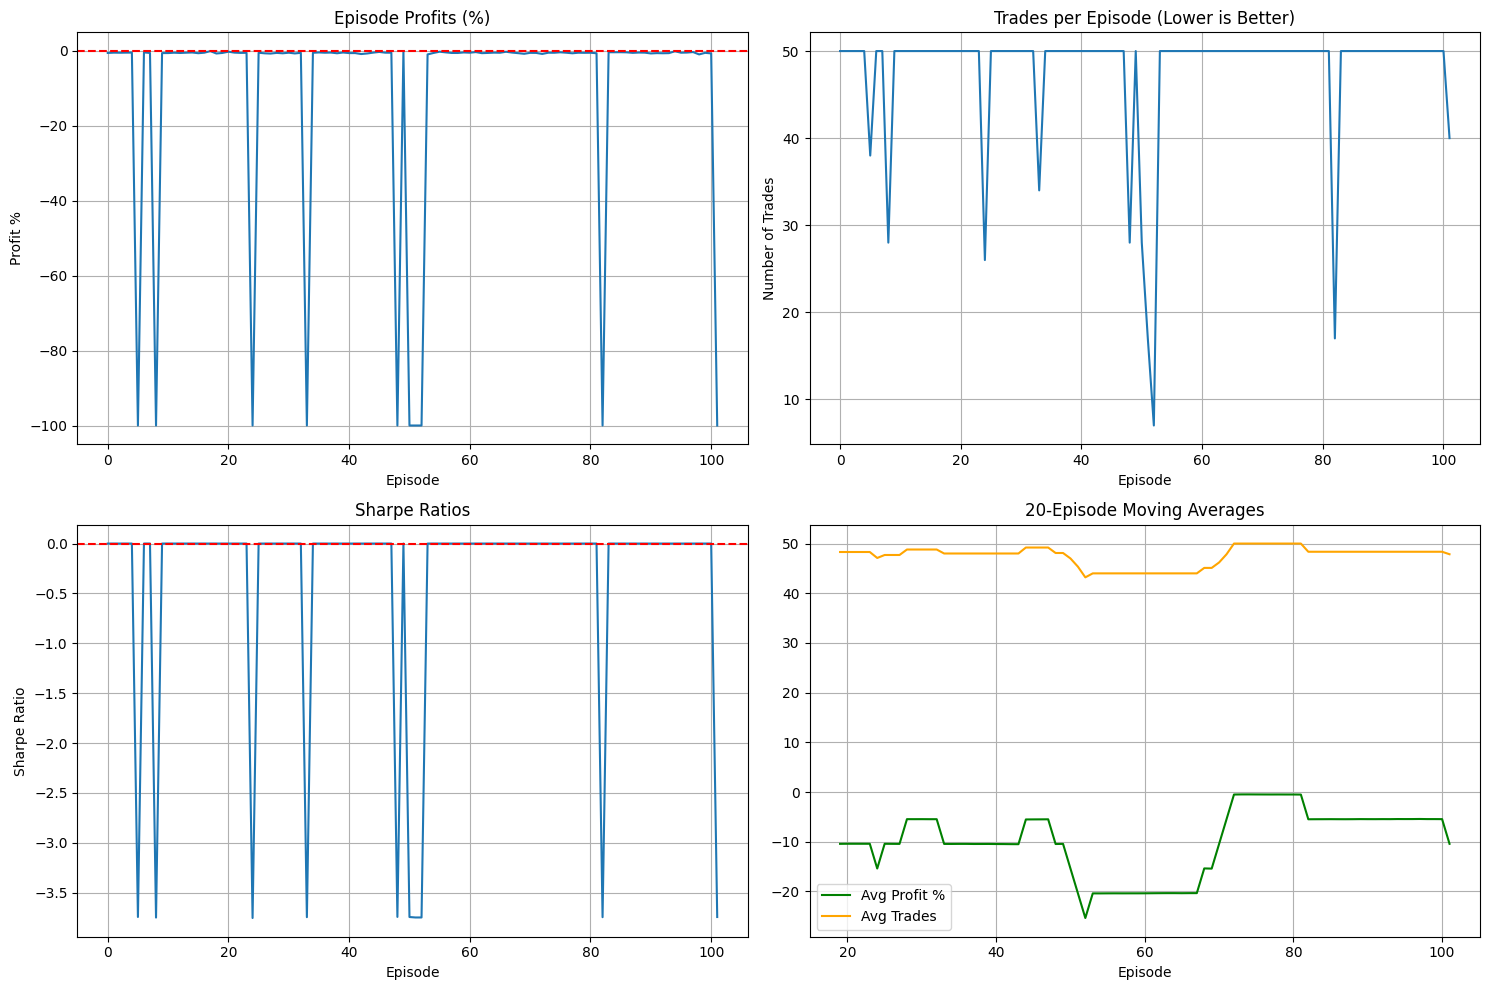


Training Summary:
Final 10-episode avg profit: -10.46%
Final 10-episode avg trades: 49.0
Final 10-episode avg Sharpe: -0.37
Running backtest on test data...

=== Advanced Backtest Results ===
Initial Balance: $10,000.00
Final Equity: $0.00
Total Return: -100.00%
Sharpe Ratio: -0.73
Max Drawdown: 100.00%
Total Trades: 15
Win Rate: 66.7%
Avg Trades per 100 bars: 3.1


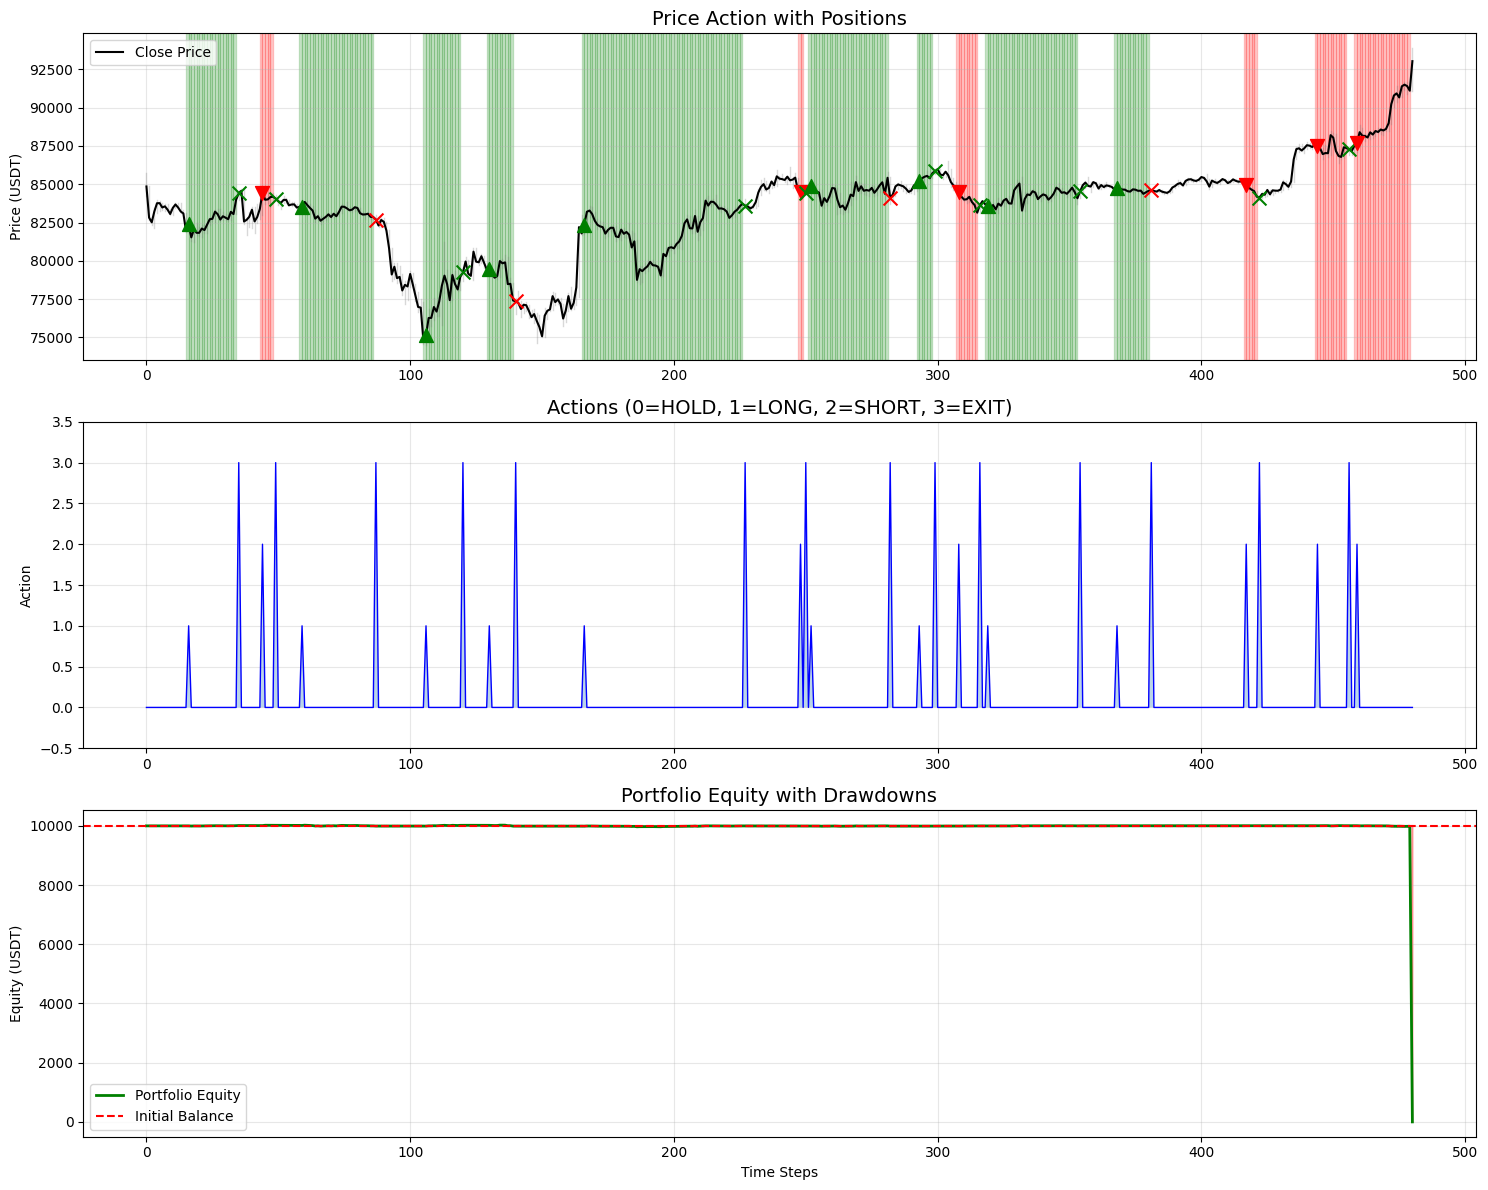


=== Buy & Hold Results ===
Total Return: 28.92%
Max Drawdown: -11.84%

=== Random Trading Results ===
Average Return: -36.30% ± 47.78%

=== Strategy Comparison ===
Advanced DQN Return: -100.00%
Advanced DQN Sharpe: -0.73
Buy & Hold Return: 28.92%
Random Trading Return: -36.30%

DQN vs Buy & Hold: -128.92%
DQN vs Random: -63.70%
Model saved to advanced_futures_dqn.pth
Results saved to advanced_results.json

=== Advanced Futures Trading Bot Complete! ===


In [ ]:
# %% [markdown]
# # Advanced Cryptocurrency Futures Trading Bot with State-of-the-Art DQN
# Improved implementation with proven techniques to prevent overtrading and liquidations

# %% [markdown]
# ## 1. Import Libraries & Setup

# %%
import ccxt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import random
from datetime import datetime
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# %% [markdown]
# ## 2. Download Bitcoin Data

# %%
def download_btc_data(symbol='BTC/USDT', timeframe='1h', days=365):
    """Download Bitcoin data from Binance"""
    exchange = ccxt.binance({
        'rateLimit': 1200,
        'enableRateLimit': True,
    })
    
    end_time = exchange.milliseconds()
    start_time = end_time - (days * 24 * 60 * 60 * 1000)
    
    print(f"Downloading {symbol} {timeframe} data...")
    all_ohlcv = []
    
    while start_time < end_time:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, start_time, 1500)
            if not ohlcv:
                break
            all_ohlcv.extend(ohlcv)
            start_time = ohlcv[-1][0] + 1
            print(f"Downloaded {len(all_ohlcv)} candles...", end='\r')
        except Exception as e:
            print(f"Error: {e}")
            break
    
    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.drop_duplicates(subset=['timestamp']).reset_index(drop=True)
    
    print(f"\nDownloaded {len(df)} candles")
    return df

# Download data
data = download_btc_data(days=365)  # 1 year for better training
print(f"Data shape: {data.shape}")

# %% [markdown]
# ## 3. Enhanced Feature Engineering

# %%
def add_advanced_features(df):
    """Add comprehensive technical indicators for futures trading"""
    df = df.copy()
    
    # Price features
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    df['high_low_ratio'] = (df['high'] - df['low']) / df['close']
    df['close_to_high'] = (df['high'] - df['close']) / df['high']
    df['close_to_low'] = (df['close'] - df['low']) / df['low']
    
    # Volatility
    df['volatility'] = df['returns'].rolling(20).std()
    df['atr'] = calculate_atr(df, 14)
    
    # Moving averages
    for period in [10, 20, 50]:
        df[f'sma_{period}'] = df['close'].rolling(period).mean()
        df[f'ema_{period}'] = df['close'].ewm(span=period).mean()
    
    df['sma_ratio_short'] = df['sma_10'] / df['sma_20']
    df['sma_ratio_long'] = df['sma_20'] / df['sma_50']
    
    # TREND FOLLOWING FEATURES (NEW)
    df['trend_20'] = (df['close'] - df['sma_20']) / df['sma_20']
    df['trend_50'] = (df['close'] - df['sma_50']) / df['sma_50']
    df['momentum_5'] = df['close'].pct_change(5)
    df['momentum_10'] = df['close'].pct_change(10)
    
    # Higher highs/lows
    df['hh'] = (df['high'] > df['high'].rolling(20).max().shift(1)).astype(float)
    df['ll'] = (df['low'] < df['low'].rolling(20).min().shift(1)).astype(float)
    
    # RSI
    df['rsi'] = calculate_rsi(df['close'], 14)
    df['rsi_ma'] = df['rsi'].rolling(10).mean()
    
    # MACD
    df['macd'], df['macd_signal'], df['macd_hist'] = calculate_macd(df['close'])
    
    # Bollinger Bands
    df['bb_middle'] = df['close'].rolling(20).mean()
    bb_std = df['close'].rolling(20).std()
    df['bb_upper'] = df['bb_middle'] + (bb_std * 2)
    df['bb_lower'] = df['bb_middle'] - (bb_std * 2)
    df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']
    
    # Volume features
    df['volume_ratio'] = df['volume'] / df['volume'].rolling(20).mean()
    df['volume_trend'] = df['volume'].rolling(10).mean() / df['volume'].rolling(50).mean()
    
    # Market microstructure
    df['spread'] = df['high'] - df['low']
    df['spread_pct'] = df['spread'] / df['close']
    
    # Clean data
    df = df.dropna()
    return df

def calculate_atr(df, period=14):
    """Calculate Average True Range"""
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr.rolling(period).mean()

def calculate_rsi(prices, period=14):
    """Calculate RSI"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(prices, fast=12, slow=26, signal=9):
    """Calculate MACD"""
    ema_fast = prices.ewm(span=fast).mean()
    ema_slow = prices.ewm(span=slow).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal).mean()
    macd_hist = macd - macd_signal
    return macd, macd_signal, macd_hist

# Add features
data = add_advanced_features(data)
print(f"Data with features: {data.shape}")

# Select features - Focus on TREND
feature_columns = [
    # Trend features (NEW)
    'trend_20', 'trend_50', 'momentum_5', 'momentum_10', 'hh', 'll',
    # Price action
    'returns', 'log_returns', 'high_low_ratio', 'close_to_high', 'close_to_low',
    # Technical indicators
    'sma_ratio_short', 'sma_ratio_long', 'rsi', 'rsi_ma', 
    'macd', 'macd_signal', 'macd_hist', 'bb_position', 'bb_width',
    # Volume and volatility
    'volume_ratio', 'volume_trend', 'volatility', 'atr', 'spread_pct'
]

# %% [markdown]
# ## 4. Advanced Futures Trading Environment

# %%
class AdvancedFuturesTradingEnv:
    """Enhanced environment with anti-overtrading and risk management"""
    
    def __init__(self, data, initial_balance=10000, fee_rate=0.0005, 
                 liquidation_threshold=0.05, max_trades_per_episode=100):
        self.data = data.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.fee_rate = fee_rate  # Reduced to 0.05%
        self.liquidation_threshold = liquidation_threshold
        self.max_trades_per_episode = max_trades_per_episode  # Increased to 100
        
        # Anti-overtrading
        self.min_holding_period = 3  # Minimum bars between trades
        self.overtrading_penalty = 0.0001  # Very small penalty
        
        # Position sizing - MUCH SMALLER
        self.max_position_pct = 0.1  # Max 10% of capital per trade
        self.min_position_pct = 0.02  # Min 2% position
        self.min_position_pct = 0.02  # Min 2% position
        self.kelly_fraction = 0.1  # Very conservative Kelly
        
        # Stop loss
        self.stop_loss_pct = 0.02  # 2% stop loss
        
        # Features
        self.feature_columns = feature_columns
        self.action_space = 4  # HOLD, LONG, SHORT, EXIT
        
        self.reset()
        
    def reset(self):
        self.current_step = 100  # Need history for indicators
        self.balance = self.initial_balance
        self.position = None
        self.entry_price = 0
        self.position_size = 0
        self.entry_step = 0
        
        # Tracking
        self.trades = []
        self.num_trades = 0
        self.consecutive_losses = 0
        self.max_drawdown = 0
        self.peak_equity = self.initial_balance
        
        # History
        self.balance_history = [self.balance]
        self.equity_history = [self.balance]
        self.action_history = []
        self.position_history = []
        
        return self._get_observation()
    
    def _get_observation(self):
        """Enhanced state representation"""
        # Market features
        features = self.data[self.feature_columns].iloc[self.current_step].values
        
        # Normalize features
        features = np.clip(features, -5, 5)  # Clip extreme values
        
        # Position features
        current_price = self.data['close'].iloc[self.current_step]
        position_features = self._get_position_features(current_price)
        
        # Risk features
        risk_features = self._get_risk_features(current_price)
        
        # Market regime features
        regime_features = self._get_market_regime_features()
        
        return np.concatenate([features, position_features, risk_features, regime_features]).astype(np.float32)
    
    def _get_position_features(self, current_price):
        """Position-specific features"""
        if self.position is None:
            return np.array([0, 0, 0, 0, 0, 0, 0])
        
        # Basic position info
        is_long = float(self.position == 'long')
        is_short = float(self.position == 'short')
        
        # P&L calculation
        if self.position == 'long':
            pnl_pct = (current_price - self.entry_price) / self.entry_price
        else:
            pnl_pct = (self.entry_price - current_price) / self.entry_price
        
        # Time in position
        bars_in_position = self.current_step - self.entry_step
        
        # Distance to liquidation
        if self.position == 'long':
            liquidation_price = self.entry_price * (1 - self.liquidation_threshold)
            distance_to_liq = (current_price - liquidation_price) / current_price
        else:
            liquidation_price = self.entry_price * (1 + self.liquidation_threshold)
            distance_to_liq = (liquidation_price - current_price) / current_price
        
        return np.array([
            is_long,
            is_short,
            self.position_size / self.initial_balance,
            pnl_pct,
            np.tanh(pnl_pct * 10),  # Scaled P&L
            bars_in_position / 100,  # Normalized time
            distance_to_liq
        ])
    
    def _get_risk_features(self, current_price):
        """Risk management features"""
        equity = self._calculate_equity(current_price)
        
        # Drawdown
        self.peak_equity = max(self.peak_equity, equity)
        current_drawdown = (self.peak_equity - equity) / self.peak_equity
        
        # Trade statistics
        win_rate = self._calculate_win_rate()
        avg_win_loss_ratio = self._calculate_avg_win_loss_ratio()
        trade_frequency = self.num_trades / max(1, self.current_step - 100)
        
        return np.array([
            self.balance / self.initial_balance,
            equity / self.initial_balance - 1,  # Total return
            current_drawdown,
            self.consecutive_losses / 5,  # Normalized
            win_rate,
            avg_win_loss_ratio,
            trade_frequency
        ])
    
    def _get_market_regime(self):
        """Detect market regime: trending, ranging, volatile"""
        if self.current_step < 50:
            return 'unknown'
        
        lookback = 50
        start = max(0, self.current_step - lookback)
        recent = self.data.iloc[start:self.current_step]
        
        # Trend detection
        trend = (recent['close'].iloc[-1] - recent['close'].iloc[0]) / recent['close'].iloc[0]
        
        # Volatility
        volatility = recent['returns'].std()
        
        # Range detection using ATR
        atr_ratio = recent['atr'].mean() / recent['close'].mean()
        
        if abs(trend) > 0.05 and volatility < 0.03:
            return 'trending'
        elif abs(trend) < 0.02 and atr_ratio < 0.01:
            return 'ranging'
        else:
            return 'volatile'
    
    def _get_trend_strength(self):
        """Get current trend strength"""
        if self.current_step < 20:
            return 0
        
        # Use trend_20 feature if available
        return self.data['trend_20'].iloc[self.current_step]
    
    def _check_liquidation(self):
        """Check liquidation using high/low prices"""
        if self.position is None:
            return False
        
        high_price = self.data['high'].iloc[self.current_step]
        low_price = self.data['low'].iloc[self.current_step]
        
        if self.position == 'long':
            worst_price = low_price
            loss_pct = (worst_price - self.entry_price) / self.entry_price
        else:
            worst_price = high_price
            loss_pct = (self.entry_price - worst_price) / self.entry_price
        
        return loss_pct <= -self.liquidation_threshold
    
    def _calculate_position_size(self, confidence=1.0):
        """Adaptive position sizing based on performance and market regime"""
        # Get performance metrics
        win_rate = self._calculate_win_rate()
        sharpe = self._calculate_sharpe_ratio()
        regime = self._get_market_regime()
        volatility = self.data['volatility'].iloc[self.current_step]
        
        # Base size
        base_size_pct = 0.05  # 5% base
        
        # Performance adjustment
        if win_rate > 0.6 and sharpe > 1:
            perf_multiplier = 1.5
        elif win_rate > 0.5:
            perf_multiplier = 1.0
        else:
            perf_multiplier = 0.5
        
        # Regime adjustment
        if regime == 'trending':
            regime_multiplier = 1.2  # Increase in trends
        elif regime == 'volatile':
            regime_multiplier = 0.7  # Decrease in volatility
        else:
            regime_multiplier = 1.0
        
        # Volatility adjustment
        if volatility > 0:
            vol_multiplier = min(1.0, 0.02 / volatility)  # Reduce in high vol
        else:
            vol_multiplier = 1.0
        
        # Calculate final size
        position_pct = base_size_pct * perf_multiplier * regime_multiplier * vol_multiplier * confidence
        
        # Clamp between min and max
        position_pct = min(self.max_position_pct, max(self.min_position_pct, position_pct))
        
        return self.balance * position_pct
    
    def _execute_action(self, action):
        """Execute action with enhanced risk management"""
        current_price = self.data['close'].iloc[self.current_step]
        
        # CRITICAL: Check stop loss BEFORE liquidation
        if self.position is not None:
            if self.position == 'long':
                loss_pct = (current_price - self.entry_price) / self.entry_price
            else:
                loss_pct = (self.entry_price - current_price) / self.entry_price
            
            # Force exit if stop loss hit
            if loss_pct <= -self.stop_loss_pct:
                action = 3  # Override to EXIT
                # Record stop loss
                self.trades.append({
                    'step': self.current_step,
                    'action': 'stop_loss',
                    'position': self.position,
                    'loss_pct': loss_pct
                })
        
        # Check liquidation after stop loss
        if self._check_liquidation():
            loss = -self.position_size
            self.balance = 0
            
            self.trades.append({
                'step': self.current_step,
                'action': 'liquidation',
                'position': self.position,
                'loss': loss
            })
            
            self.consecutive_losses += 1
            self.position = None
            self.position_size = 0
            
            return -1.0  # Maximum penalty
        
        # Anti-overtrading: enforce minimum holding period
        if self.position is not None and self.min_holding_period > 0:
            bars_held = self.current_step - self.entry_step
            if bars_held < self.min_holding_period and action == 3:
                return -0.001  # Small penalty for trying to exit too early
        
        # Execute actions
        reward = 0
        
        if action == 0:  # HOLD
            pass
            
        elif action == 1 and self.position is None:  # LONG
            if self.num_trades < self.max_trades_per_episode:
                self.position_size = self._calculate_position_size(confidence=1.0)
                fee = self.position_size * self.fee_rate
                
                if self.position_size + fee <= self.balance:
                    self.balance -= (self.position_size + fee)
                    self.position = 'long'
                    self.entry_price = current_price
                    self.entry_step = self.current_step
                    self.num_trades += 1
                    
                    self.trades.append({
                        'step': self.current_step,
                        'action': 'open_long',
                        'price': current_price,
                        'size': self.position_size
                    })
            
        elif action == 2 and self.position is None:  # SHORT
            if self.num_trades < self.max_trades_per_episode:
                self.position_size = self._calculate_position_size(confidence=1.0)
                fee = self.position_size * self.fee_rate
                
                if self.position_size + fee <= self.balance:
                    self.balance -= (self.position_size + fee)
                    self.position = 'short'
                    self.entry_price = current_price
                    self.entry_step = self.current_step
                    self.num_trades += 1
                    
                    self.trades.append({
                        'step': self.current_step,
                        'action': 'open_short',
                        'price': current_price,
                        'size': self.position_size
                    })
            
        elif action == 3 and self.position is not None:  # EXIT
            # Calculate P&L
            if self.position == 'long':
                pnl_pct = (current_price - self.entry_price) / self.entry_price
            else:
                pnl_pct = (self.entry_price - current_price) / self.entry_price
            
            gross_pnl = self.position_size * pnl_pct
            exit_fee = self.position_size * self.fee_rate
            net_pnl = gross_pnl - exit_fee
            
            self.balance += self.position_size + net_pnl
            
            # Update consecutive losses
            if net_pnl < 0:
                self.consecutive_losses += 1
            else:
                self.consecutive_losses = 0
            
            self.trades.append({
                'step': self.current_step,
                'action': f'close_{self.position}',
                'entry_price': self.entry_price,
                'exit_price': current_price,
                'pnl': net_pnl,
                'pnl_pct': pnl_pct
            })
            
            # Position-based reward with exit bonus
            if pnl_pct > 0:
                # Reward profitable exits more
                reward = pnl_pct * 0.2 + 0.01  # Exit bonus
            else:
                # Smaller penalty for losses
                reward = pnl_pct * 0.1
            
            self.position = None
            self.position_size = 0
        
        return reward
    
    def _calculate_equity(self, current_price):
        """Calculate current equity"""
        if self.position is None:
            return self.balance
        
        if self.position == 'long':
            unrealized_pnl = self.position_size * ((current_price - self.entry_price) / self.entry_price)
        else:
            unrealized_pnl = self.position_size * ((self.entry_price - current_price) / self.entry_price)
        
        return self.balance + self.position_size + unrealized_pnl
    
    def _calculate_win_rate(self):
        """Calculate historical win rate"""
        if not self.trades:
            return 0.5  # Default 50% win rate
        
        wins = sum(1 for t in self.trades if t.get('pnl', 0) > 0)
        total = sum(1 for t in self.trades if 'pnl' in t)
        
        if total == 0:
            return 0.5  # Default if no closed trades
        
        return wins / total
    
    def _calculate_avg_win_loss_ratio(self):
        """Calculate average win/loss ratio"""
        if not self.trades:
            return 1.5  # Default optimistic ratio
        
        wins = [t['pnl'] for t in self.trades if t.get('pnl', 0) > 0]
        losses = [abs(t['pnl']) for t in self.trades if t.get('pnl', 0) < 0]
        
        avg_win = np.mean(wins) if wins else 100  # Default win size
        avg_loss = np.mean(losses) if losses else 100  # Default loss size
        
        return avg_win / max(avg_loss, 1e-6)
    
    def _calculate_sharpe_ratio(self):
        """Calculate Sharpe ratio of returns"""
        if len(self.equity_history) < 20:
            return 0
        
        # Get last 20 equity values
        equity_array = np.array(self.equity_history[-20:])
        # Calculate returns: (price[t] - price[t-1]) / price[t-1]
        returns = np.diff(equity_array) / equity_array[:-1]
        
        if len(returns) > 0 and returns.std() > 0:
            return np.sqrt(252) * returns.mean() / returns.std()  # Annualized
        return 0
    
    def step(self, action):
        """Execute one step with comprehensive reward calculation"""
        # Execute action
        action_reward = self._execute_action(action)
        
        # Calculate comprehensive reward
        current_price = self.data['close'].iloc[self.current_step]
        equity = self._calculate_equity(current_price)
        
        # Update drawdown
        self.peak_equity = max(self.peak_equity, equity)
        drawdown = (self.peak_equity - equity) / self.peak_equity
        self.max_drawdown = max(self.max_drawdown, drawdown)
        
        # Composite reward function
        prev_equity = self.equity_history[-1] if self.equity_history else self.initial_balance
        equity_change = (equity - prev_equity) / self.initial_balance
        
        # Sharpe ratio component
        sharpe = self._calculate_sharpe_ratio()
        
        # Get trend strength for reward calculation
        trend_strength = self._get_trend_strength()
        
        # TREND FOLLOWING REWARDS
        trend_reward = 0
        if self.position == 'long' and trend_strength > 0:
            # Reward being long in uptrend
            trend_reward = 0.005 * trend_strength
        elif self.position == 'short' and trend_strength < 0:
            # Reward being short in downtrend
            trend_reward = 0.005 * abs(trend_strength)
        elif self.position == 'long' and trend_strength < -0.02:
            # Penalize counter-trend long
            trend_reward = -0.01
        elif self.position == 'short' and trend_strength > 0.02:
            # Penalize counter-trend short
            trend_reward = -0.01
        
        # Anti-overtrading component (reduced penalty)
        trade_penalty = -self.overtrading_penalty if action in [1, 2] else 0
        
        # Encourage profitable position closing with trend bonus
        exit_bonus = 0
        if action == 3 and self.position is not None:
            # Calculate potential P&L
            if self.position == 'long':
                potential_pnl = (current_price - self.entry_price) / self.entry_price
            else:
                potential_pnl = (self.entry_price - current_price) / self.entry_price
            
            if potential_pnl > 0.001:  # 0.1% profit
                # Bigger bonus if exiting with trend
                trend_multiplier = 1 + abs(trend_strength)
                exit_bonus = 0.01 * trend_multiplier
        
        # Penalty for holding losing position too long
        holding_penalty = 0
        if self.position is not None:
            bars_held = self.current_step - self.entry_step
            if self.position == 'long':
                current_pnl = (current_price - self.entry_price) / self.entry_price
            else:
                current_pnl = (self.entry_price - current_price) / self.entry_price
            
            if current_pnl < -0.01 and bars_held > 5:  # -1% loss and held > 5 bars
                holding_penalty = -0.005
        
        # Risk-adjusted reward with trend following
        reward = (
            0.4 * action_reward +           # Direct P&L
            0.2 * equity_change +            # Portfolio growth
            0.2 * trend_reward +             # Trend following (NEW)
            0.1 * sharpe * 0.01 +           # Risk-adjusted returns
            0.05 * (-drawdown * 0.1) +      # Drawdown penalty
            trade_penalty +                  # Overtrading penalty
            exit_bonus +                     # Exit bonus
            holding_penalty                  # Penalty for holding losers
        )
        
        # Clip reward
        reward = np.clip(reward, -1, 1)
        
        # Update history
        self.balance_history.append(self.balance)
        self.equity_history.append(equity)
        self.action_history.append(action)
        self.position_history.append(
            0 if self.position is None else (1 if self.position == 'long' else 2)
        )
        
        # Move to next step
        self.current_step += 1
        
        # Episode ends if: out of data, no equity, or reached max steps
        max_steps = min(len(self.data) - 1, self.current_step + 1000)  # At least 1000 steps
        done = (self.current_step >= max_steps) or (equity <= 0)
        
        next_obs = self._get_observation() if not done else np.zeros_like(self._get_observation())
        
        info = {
            'equity': equity,
            'drawdown': drawdown,
            'num_trades': self.num_trades,
            'position': self.position
        }
        
        return next_obs, reward, done, info

# Test environment
env = AdvancedFuturesTradingEnv(data)
obs = env.reset()
print(f"Observation shape: {obs.shape}")
print(f"Features: market({len(feature_columns)}) + position(7) + risk(7) + regime(5) = {obs.shape[0]}")

# %% [markdown]
# ## 5. Dueling DQN with Noisy Networks

# %%
class NoisyLinear(nn.Module):
    """Noisy linear layer for exploration"""
    def __init__(self, in_features, out_features, std_init=0.5):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init
        
        # Learnable parameters
        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))
        
        # Factorized noise
        self.register_buffer('weight_epsilon', torch.empty(out_features, in_features))
        self.register_buffer('bias_epsilon', torch.empty(out_features))
        
        self.reset_parameters()
        self.reset_noise()
    
    def reset_parameters(self):
        mu_range = 1 / np.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / np.sqrt(self.in_features))
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / np.sqrt(self.out_features))
    
    def reset_noise(self):
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)
    
    def _scale_noise(self, size):
        x = torch.randn(size)
        return x.sign().mul_(x.abs().sqrt_())
    
    def forward(self, x):
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        
        return F.linear(x, weight, bias)

class DuelingDQN(nn.Module):
    """Dueling DQN with Noisy Networks"""
    def __init__(self, state_dim, action_dim, hidden_dim=512, noisy=True):
        super().__init__()
        self.noisy = noisy
        
        # Shared layers
        self.shared_fc1 = nn.Linear(state_dim, hidden_dim)
        self.shared_fc2 = nn.Linear(hidden_dim, hidden_dim)
        
        # Value stream
        if noisy:
            self.value_fc = NoisyLinear(hidden_dim, hidden_dim // 2)
            self.value_out = NoisyLinear(hidden_dim // 2, 1)
        else:
            self.value_fc = nn.Linear(hidden_dim, hidden_dim // 2)
            self.value_out = nn.Linear(hidden_dim // 2, 1)
        
        # Advantage stream
        if noisy:
            self.advantage_fc = NoisyLinear(hidden_dim, hidden_dim // 2)
            self.advantage_out = NoisyLinear(hidden_dim // 2, action_dim)
        else:
            self.advantage_fc = nn.Linear(hidden_dim, hidden_dim // 2)
            self.advantage_out = nn.Linear(hidden_dim // 2, action_dim)
        
        # Normalization layers
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, state):
        # Shared network
        x = F.relu(self.ln1(self.shared_fc1(state)))
        x = self.dropout(x)
        x = F.relu(self.ln2(self.shared_fc2(x)))
        x = self.dropout(x)
        
        # Value stream
        value = F.relu(self.value_fc(x))
        value = self.value_out(value)
        
        # Advantage stream
        advantage = F.relu(self.advantage_fc(x))
        advantage = self.advantage_out(advantage)
        
        # Combine streams
        q_values = value + advantage - advantage.mean(dim=-1, keepdim=True)
        
        return q_values
    
    def reset_noise(self):
        """Reset noise layers"""
        if self.noisy:
            self.value_fc.reset_noise()
            self.value_out.reset_noise()
            self.advantage_fc.reset_noise()
            self.advantage_out.reset_noise()

# %% [markdown]
# ## 6. Prioritized Experience Replay

# %%
class PrioritizedReplayBuffer:
    """Prioritized Experience Replay Buffer"""
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_end=1.0, beta_steps=100000):
        self.capacity = capacity
        self.alpha = alpha
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.beta_steps = beta_steps
        self.frame = 0
        
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.position = 0
        
    def push(self, state, action, next_state, reward, done):
        max_priority = self.priorities.max() if self.buffer else 1.0
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, next_state, reward, done))
        else:
            self.buffer[self.position] = (state, action, next_state, reward, done)
        
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        if len(self.buffer) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.position]
        
        # Calculate sampling probabilities
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        samples = [self.buffer[idx] for idx in indices]
        
        # Calculate importance sampling weights
        beta = min(1.0, self.beta_start + (self.beta_end - self.beta_start) * self.frame / self.beta_steps)
        self.frame += 1
        
        weights = (len(self.buffer) * probabilities[indices]) ** (-beta)
        weights /= weights.max()
        
        batch = list(zip(*samples))
        states = torch.FloatTensor(batch[0])
        actions = torch.LongTensor(batch[1])
        next_states = torch.FloatTensor(batch[2])
        rewards = torch.FloatTensor(batch[3])
        dones = torch.FloatTensor(batch[4])
        weights = torch.FloatTensor(weights)
        
        return states, actions, next_states, rewards, dones, weights, indices
    
    def update_priorities(self, indices, td_errors):
        """Update priorities with bonus for profitable trades"""
        for idx, td_error in zip(indices, td_errors):
            # Base priority from TD error
            base_priority = abs(td_error) + 1e-6
            
            # Get transition details if available
            if idx < len(self.buffer):
                transition = self.buffer[idx]
                reward = transition.reward if hasattr(transition, 'reward') else 0
                
                # Bonus for profitable transitions
                if reward > 0:
                    base_priority *= 2.0
                
                # Extra bonus for large rewards (good trades)
                if reward > 0.01:
                    base_priority *= 3.0
            
            self.priorities[idx] = base_priority
    
    def __len__(self):
        return len(self.buffer)

# %% [markdown]
# ## 7. Advanced DQN Agent

# %%
class AdvancedDQNAgent:
    """DQN Agent with all state-of-the-art improvements"""
    def __init__(self, state_size, action_size, lr=1e-4):  # Increased learning rate
        self.state_size = state_size
        self.action_size = action_size
        
        # Networks
        self.q_network = DuelingDQN(state_size, action_size, noisy=True).to(device)
        self.target_network = DuelingDQN(state_size, action_size, noisy=True).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Optimizer with gradient clipping
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        # Memory
        self.memory = PrioritizedReplayBuffer(100000)
        
        # Parameters
        self.gamma = 0.99
        self.tau = 0.01  # Faster soft update
        self.batch_size = 32  # Smaller batch for faster learning
        self.update_every = 2  # Update more frequently
        self.steps = 0
        
        # Epsilon for initial exploration (in addition to noisy nets)
        self.epsilon = 0.8  # Start with high exploration for curriculum learning
        self.epsilon_min = 0.1  # Higher minimum
        self.epsilon_decay = 0.995
        
        # For tracking
        self.losses = []
        self.q_values = []
    
    def act(self, state, env=None, training=True):
        """Select action using noisy networks with epsilon-greedy backup"""
        # Valid action masking
        valid_actions = [0]  # HOLD always valid
        if env and env.position is None:
            valid_actions.extend([1, 2])  # Can open position
        elif env and env.position is not None:
            valid_actions.append(3)  # Can close position
        
        # Epsilon-greedy exploration (in addition to noisy networks)
        if training and random.random() < self.epsilon:
            # Force diverse actions in early training
            if env and env.position is None:
                # When no position, prefer opening positions
                if random.random() < 0.7:
                    return random.choice([1, 2])  # 70% chance LONG or SHORT
                else:
                    return 0  # 30% chance HOLD
            else:
                # When have position, encourage exit after some time
                bars_held = env.current_step - env.entry_step if hasattr(env, 'entry_step') else 0
                
                # Progressive exit probability
                if bars_held > 10:
                    exit_prob = 0.7  # 70% exit after 10 bars
                elif bars_held > 5:
                    exit_prob = 0.5  # 50% exit after 5 bars
                elif bars_held > 3:
                    exit_prob = 0.3  # 30% exit after 3 bars
                else:
                    exit_prob = 0.1  # 10% immediate exit
                
                if random.random() < exit_prob:
                    return 3  # EXIT
                else:
                    return 0  # HOLD
            
            return random.choice(valid_actions)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        self.q_network.eval()
        with torch.no_grad():
            q_values = self.q_network(state_tensor).cpu().numpy()[0]
            self.q_values.append(q_values)
        self.q_network.train()
        
        # Mask invalid actions
        masked_q_values = np.full(self.action_size, -np.inf)
        for action in valid_actions:
            masked_q_values[action] = q_values[action]
        
        return np.argmax(masked_q_values)
    
    def step(self, state, action, next_state, reward, done, env):
        # Store experience
        self.memory.push(state, action, next_state, reward, done)
        
        # Learn every UPDATE_EVERY steps
        self.steps += 1
        if self.steps % self.update_every == 0 and len(self.memory) > self.batch_size:
            self.learn()
    
    def learn(self):
        """Update network with prioritized experience replay"""
        # Sample from memory
        states, actions, next_states, rewards, dones, weights, indices = self.memory.sample(self.batch_size)
        
        states = states.to(device)
        actions = actions.to(device)
        next_states = next_states.to(device)
        rewards = rewards.to(device)
        dones = dones.to(device)
        weights = weights.to(device)
        
        # Current Q values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Double DQN
        with torch.no_grad():
            # Online network selects actions
            next_actions = self.q_network(next_states).argmax(1)
            # Target network evaluates
            next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        
        # TD errors for prioritized replay
        td_errors = (current_q_values - target_q_values).detach().cpu().numpy()
        self.memory.update_priorities(indices, td_errors)
        
        # Weighted loss
        loss = (weights * F.mse_loss(current_q_values, target_q_values, reduction='none')).mean()
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        
        # Reset noise
        self.q_network.reset_noise()
        self.target_network.reset_noise()
        
        # Soft update target network
        self.soft_update()
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        self.losses.append(loss.item())
    
    def soft_update(self):
        """Soft update of target network"""
        for target_param, param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

# %% [markdown]
# ## 8. Training with Early Stopping

# %%
def train_advanced_agent(agent, env, episodes=500, early_stop_patience=50):
    """Train agent with curriculum learning and validation"""
    
    episode_rewards = []
    episode_profits = []
    episode_trades = []
    episode_sharpes = []
    
    best_profit = -np.inf
    patience_counter = 0
    
    print("Training Advanced DQN Agent with Curriculum Learning...")
    
    for episode in range(episodes):
        # CURRICULUM LEARNING
        if episode < 100:
            # Phase 1: High exploration, learn trends
            agent.epsilon = max(0.8, agent.epsilon)
            print_phase = "Phase 1: Learning Trends" if episode == 0 else None
        elif episode < 200:
            # Phase 2: Medium exploration, learn exits
            agent.epsilon = max(0.5, agent.epsilon * 0.995)
            print_phase = "Phase 2: Learning Exits" if episode == 100 else None
        else:
            # Phase 3: Normal training
            agent.epsilon = max(0.1, agent.epsilon * 0.995)
            print_phase = "Phase 3: Full Trading" if episode == 200 else None
        
        if print_phase:
            print(f"\n{print_phase}")
        
        state = env.reset()
        total_reward = 0
        
        # Run full episode
        while True:
            action = agent.act(state, env)
            next_state, reward, done, info = env.step(action)
            agent.step(state, action, next_state, reward, done, env)
            
            state = next_state
            total_reward += reward
            
            if done:
                break
        
        # Calculate metrics
        final_equity = info['equity']
        profit = (final_equity / env.initial_balance - 1) * 100
        sharpe = env._calculate_sharpe_ratio()
        
        episode_rewards.append(total_reward)
        episode_profits.append(profit)
        episode_trades.append(env.num_trades)
        episode_sharpes.append(sharpe)
        
        # Early stopping based on profit
        if profit > best_profit:
            best_profit = profit
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= early_stop_patience and episode > 200:  # Wait for phase 3
            print(f"\nEarly stopping at episode {episode}")
            break
        
        if episode % 10 == 0:
            avg_trades = np.mean(episode_trades[-10:])
            avg_profit = np.mean(episode_profits[-10:])
            avg_sharpe = np.mean(episode_sharpes[-10:]) if episode_sharpes[-10:] else 0
            
            print(f"Episode {episode}: Profit: {profit:.2f}%, Trades: {env.num_trades}, "
                  f"Sharpe: {sharpe:.2f}, Avg Profit: {avg_profit:.2f}%, "
                  f"Epsilon: {agent.epsilon:.3f}")
    
    return {
        'episode_rewards': episode_rewards,
        'episode_profits': episode_profits,
        'episode_trades': episode_trades,
        'episode_sharpes': episode_sharpes
    }

# Split data
train_size = int(0.8 * len(data))
train_data = data[:train_size].copy()
test_data = data[train_size:].copy()

print(f"Train data: {len(train_data)} samples")
print(f"Test data: {len(test_data)} samples")

# Create environments
train_env = AdvancedFuturesTradingEnv(train_data)
test_env = AdvancedFuturesTradingEnv(test_data)

# Initialize agent
state_size = train_env.reset().shape[0]
action_size = 4
agent = AdvancedDQNAgent(state_size, action_size)

# Train agent
training_results = train_advanced_agent(agent, train_env, episodes=500)  # More episodes

# %% [markdown]
# ## 9. Training Analysis

# %%
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Profits
ax1.plot(training_results['episode_profits'])
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_title('Episode Profits (%)')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Profit %')
ax1.grid(True)

# Number of trades (should decrease)
ax2.plot(training_results['episode_trades'])
ax2.set_title('Trades per Episode (Lower is Better)')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Number of Trades')
ax2.grid(True)

# Sharpe ratios
ax3.plot(training_results['episode_sharpes'])
ax3.axhline(y=0, color='r', linestyle='--')
ax3.set_title('Sharpe Ratios')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Sharpe Ratio')
ax3.grid(True)

# Moving averages
window = 20
if len(training_results['episode_profits']) >= window:
    ma_profits = pd.Series(training_results['episode_profits']).rolling(window).mean()
    ma_trades = pd.Series(training_results['episode_trades']).rolling(window).mean()
    
    ax4.plot(ma_profits, label='Avg Profit %', color='green')
    ax4.plot(ma_trades, label='Avg Trades', color='orange')
    ax4.set_title(f'{window}-Episode Moving Averages')
    ax4.set_xlabel('Episode')
    ax4.legend()
    ax4.grid(True)

plt.tight_layout()
plt.show()

print(f"\nTraining Summary:")
print(f"Final 10-episode avg profit: {np.mean(training_results['episode_profits'][-10:]):.2f}%")
print(f"Final 10-episode avg trades: {np.mean(training_results['episode_trades'][-10:]):.1f}")
print(f"Final 10-episode avg Sharpe: {np.mean(training_results['episode_sharpes'][-10:]):.2f}")

# %% [markdown]
# ## 10. Enhanced Backtesting

# %%
def backtest_advanced(agent, env, plot=True):
    """Backtest with comprehensive metrics"""
    state = env.reset()
    
    actions = []
    prices = []
    highs = []
    lows = []
    equities = []
    positions = []
    
    while True:
        action = agent.act(state, env)
        state, reward, done, info = env.step(action)
        
        actions.append(action)
        step_idx = env.current_step - 1
        prices.append(env.data['close'].iloc[step_idx])
        highs.append(env.data['high'].iloc[step_idx])
        lows.append(env.data['low'].iloc[step_idx])
        equities.append(info['equity'])
        positions.append(env.position_history[-1] if env.position_history else 0)
        
        if done:
            break
    
    # Calculate comprehensive metrics
    final_equity = equities[-1]
    final_return = (final_equity / env.initial_balance - 1) * 100
    
    # Risk metrics
    equity_array = np.array(equities)
    returns = []
    if len(equity_array) > 1:
        returns = np.diff(equity_array) / equity_array[:-1]
    
    sharpe_ratio = 0
    if len(returns) > 0 and returns.std() > 0:
        sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std()
    
    max_dd = env.max_drawdown * 100
    
    # Trade analysis
    total_trades = env.num_trades
    winning_trades = sum(1 for t in env.trades if t.get('pnl', 0) > 0)
    win_rate = (winning_trades / max(1, total_trades)) * 100
    
    print(f"\n=== Advanced Backtest Results ===")
    print(f"Initial Balance: ${env.initial_balance:,.2f}")
    print(f"Final Equity: ${final_equity:,.2f}")
    print(f"Total Return: {final_return:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_dd:.2f}%")
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.1f}%")
    print(f"Avg Trades per 100 bars: {total_trades / (len(prices) / 100):.1f}")
    
    if plot:
        plot_backtest_results(env, prices, highs, lows, actions, equities, positions)
    
    return {
        'final_return': final_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_dd,
        'total_trades': total_trades,
        'win_rate': win_rate,
        'equities': equities
    }

def plot_backtest_results(env, prices, highs, lows, actions, equities, positions):
    """Enhanced plotting with trade markers"""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    
    x = range(len(prices))
    
    # Price chart with positions
    for i in x:
        ax1.plot([i, i], [lows[i], highs[i]], color='gray', alpha=0.3, linewidth=1)
    
    ax1.plot(x, prices, label='Close Price', color='black', linewidth=1.5)
    
    # Color background by position
    for i in range(1, len(positions)):
        if positions[i] == 1:  # Long
            ax1.axvspan(i-1, i, alpha=0.2, color='green')
        elif positions[i] == 2:  # Short
            ax1.axvspan(i-1, i, alpha=0.2, color='red')
    
    # Trade markers
    for trade in env.trades:
        idx = trade['step'] - 100  # Adjust for initial offset
        if 0 <= idx < len(prices):
            if trade['action'] == 'open_long':
                ax1.scatter(idx, trade['price'], marker='^', color='green', s=100, zorder=5)
            elif trade['action'] == 'open_short':
                ax1.scatter(idx, trade['price'], marker='v', color='red', s=100, zorder=5)
            elif trade['action'] in ['close_long', 'close_short']:
                color = 'green' if trade.get('pnl', 0) > 0 else 'red'
                ax1.scatter(idx, trade['exit_price'], marker='x', color=color, s=100, zorder=5)
    
    ax1.set_title('Price Action with Positions', fontsize=14)
    ax1.set_ylabel('Price (USDT)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Actions
    ax2.plot(actions, color='blue', linewidth=1)
    ax2.fill_between(range(len(actions)), actions, alpha=0.3)
    ax2.set_title('Actions (0=HOLD, 1=LONG, 2=SHORT, 3=EXIT)', fontsize=14)
    ax2.set_ylabel('Action')
    ax2.set_ylim(-0.5, 3.5)
    ax2.grid(True, alpha=0.3)
    
    # Portfolio equity with drawdown shading
    ax3.plot(equities, label='Portfolio Equity', color='green', linewidth=2)
    ax3.axhline(y=env.initial_balance, color='red', linestyle='--', label='Initial Balance')
    
    # Shade drawdowns
    peak = env.initial_balance
    for i, equity in enumerate(equities):
        if equity > peak:
            peak = equity
        if equity < peak:
            ax3.fill_between([i-1, i], [peak, peak], [equities[i-1], equity], 
                           color='red', alpha=0.3)
    
    ax3.set_title('Portfolio Equity with Drawdowns', fontsize=14)
    ax3.set_xlabel('Time Steps')
    ax3.set_ylabel('Equity (USDT)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run backtest
print("Running backtest on test data...")
test_results = backtest_advanced(agent, test_env)

# %% [markdown]
# ## 11. Compare with Baseline Strategies

# %%
def buy_and_hold_backtest(data, initial_balance=10000):
    """Buy and hold benchmark"""
    start_price = data['close'].iloc[100]
    end_price = data['close'].iloc[-1]
    
    final_value = (initial_balance / start_price) * end_price
    total_return = (final_value / initial_balance - 1) * 100
    
    # Calculate max drawdown
    prices = data['close'].iloc[100:]
    cumulative_returns = (initial_balance / start_price) * prices
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min() * 100
    
    print(f"\n=== Buy & Hold Results ===")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    
    return total_return, max_drawdown

def random_trading_backtest(env_data, n_simulations=100):
    """Random trading baseline"""
    returns = []
    
    for _ in range(n_simulations):
        env = AdvancedFuturesTradingEnv(env_data)
        state = env.reset()
        
        while True:
            # Random valid action
            if env.position is None:
                action = np.random.choice([0, 1, 2])  # HOLD, LONG, SHORT
            else:
                action = np.random.choice([0, 3])  # HOLD, EXIT
            
            _, _, done, info = env.step(action)
            if done:
                break
        
        final_return = (info['equity'] / env.initial_balance - 1) * 100
        returns.append(final_return)
    
    avg_return = np.mean(returns)
    std_return = np.std(returns)
    
    print(f"\n=== Random Trading Results ===")
    print(f"Average Return: {avg_return:.2f}% ± {std_return:.2f}%")
    
    return avg_return, std_return

# Run comparisons
bh_return, bh_dd = buy_and_hold_backtest(test_data)
random_return, random_std = random_trading_backtest(test_data, n_simulations=50)

print(f"\n=== Strategy Comparison ===")
print(f"Advanced DQN Return: {test_results['final_return']:.2f}%")
print(f"Advanced DQN Sharpe: {test_results['sharpe_ratio']:.2f}")
print(f"Buy & Hold Return: {bh_return:.2f}%")
print(f"Random Trading Return: {random_return:.2f}%")
print(f"\nDQN vs Buy & Hold: {test_results['final_return'] - bh_return:+.2f}%")
print(f"DQN vs Random: {test_results['final_return'] - random_return:+.2f}%")

# %% [markdown]
# ## 12. Save Model and Results

# %%
# Save model
model_path = Path('advanced_futures_dqn.pth')
torch.save({
    'model_state_dict': agent.q_network.state_dict(),
    'target_state_dict': agent.target_network.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
}, model_path)

print(f"Model saved to {model_path}")

# Save comprehensive results
results = {
    'test_results': {
        'final_return': test_results['final_return'],
        'sharpe_ratio': test_results['sharpe_ratio'],
        'max_drawdown': test_results['max_drawdown'],
        'total_trades': test_results['total_trades'],
        'win_rate': test_results['win_rate']
    },
    'training_results': {
        'final_profit': training_results['episode_profits'][-1],
        'final_trades': training_results['episode_trades'][-1],
        'final_sharpe': training_results['episode_sharpes'][-1]
    },
    'comparison': {
        'buy_hold_return': bh_return,
        'random_return': random_return,
        'outperformance_bh': test_results['final_return'] - bh_return,
        'outperformance_random': test_results['final_return'] - random_return
    },
    'model_config': {
        'architecture': 'Dueling DQN with Noisy Networks',
        'replay': 'Prioritized Experience Replay',
        'features': len(feature_columns),
        'hidden_dim': 512,
        'learning_rate': 5e-5
    },
    'timestamp': datetime.now().isoformat()
}

with open('advanced_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to advanced_results.json")
print("\n=== Advanced Futures Trading Bot Complete! ===")